# Iterative methods for solving linear systems




Let us consider an elastic cable fixed at the extremes occupying at rest the space $[0,1]$. We apply on it a given force $f(x)$. Its displacement at the point $x$, $u(x)$ is the solution of the following problem:
$$
-u_h''(x) = f(x)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h(1) = 0
$$

For the sake of simplicity we consider a uniform discretisation of the interval $[0,1]$ using $n$ equispaced *sample points* to construct a **Finite Difference Approximation**.

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import numpy.linalg

n = 33
h = 1./(n-1)

x=linspace(0,1,n)

# Central finite difference approximation

We consider the approximation

$$
-u''_i := \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$

and solve the linear system

$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad i=1,\ldots,n-2
$$

This results in a tridiagonal matrix with $n-2$ entries. We assemble all of the entries anyway, and then perform a **line elimination** to make the system solvable. This is typical of problems with **Dirichlet Boundary conditions**.

In [2]:
a = -ones((n-1,)) # Offdiagonal entries
b = 2*ones((n,)) # Diagonal entries
A = (diag(a, -1) + diag(b, 0) + diag(a, +1))
print(A)

# Now we scale it to 1/h^2
A /= h**2

print(linalg.cond(A))

[[ 2. -1.  0. ...,  0.  0.  0.]
 [-1.  2. -1. ...,  0.  0.  0.]
 [ 0. -1.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  2. -1.  0.]
 [ 0.  0.  0. ..., -1.  2. -1.]
 [ 0.  0.  0. ...,  0. -1.  2.]]
467.842628839


Now let's consider a simple right hand side:

$$
f_i = x_i(1-x_i)
$$
which gives as exact solution

$$
u_{\mathrm{exact}} = \frac{x^4}{12} - \frac{x^3}{6} +\frac{x}{12}
$$


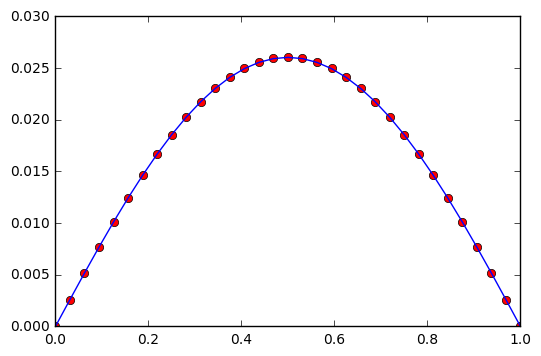

In [3]:
f =x*(1.-x)

# Imposing homogeneous BCs keeping A SPD
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1.

A[:,-1] = 0
A[-1,:] = 0
A[-1,-1] = 1

f[0] = 0
f[-1] = 0

A1 = A.copy()

u = linalg.solve(A1, f)

u_ex = (x**4)/12. - (x**3)/6. + x/12.

_ = plot(x,u,'ro')
_ = plot(x,u_ex)


## Jacobi

$$ 
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j\neq i} a_{ij}x_j^k\right)
$$



In [23]:
s = arange(16).reshape((4,4))

s

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [46]:
def jacobi(A,b,nmax=10000,eps=1e-10):
    n = len(b)
    x = zeros_like(b)
    x_old = zeros_like(b)
    it = 0
    tol = eps+1
    while (it < nmax and tol > eps):
        it += 1
        for i in range(n):
            x[i] = 1/A[i,i] * ( b [i] - dot( A[i,:i], x_old[:i] ) - dot( A[i,i+1:], x_old[i+1:] ) )
            
        res = b - dot(A,x)
        tol = numpy.linalg.norm(res,2)
        
        x_old = x.copy()
    
    print it, tol
    return x

sol_jacobi = jacobi(A,f)
numpy.linalg.norm(u_ex - sol_jacobi,2)

4777 9.99278393347e-11


8.4049067552872592e-05

## Gauss-Seidel

$$ 
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j=0}^{i-1} a_{ij}x_j^{k+1} - \sum_{j=i+1}^{N} a_{ij}x_j^k\right)
$$

In [47]:
def GS(A,b,nmax=10000,eps=1e-10):
    n = len(b)
    x = zeros_like(b)
    x_old = zeros_like(b)
    it = 0
    tol = eps+1
    while (it < nmax and tol > eps):
        it += 1
        for i in range(n):
            x[i] = 1/A[i,i] * ( b [i] - dot( A[i,:i], x[:i] ) - dot( A[i,i+1:], x_old[i+1:] ) )
            
        res = b - dot(A,x)
        tol = numpy.linalg.norm(res,2)
        
        x_old = x.copy()
    
    print it, tol
    return x

sol_GS = GS(A,f)
numpy.linalg.norm(u_ex - sol_GS,2)

2390 9.95304639169e-11


8.4049067666181233e-05

   ## Gradient method
   $$
   {\bf r}^k = {\bf b} - A {\bf x}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf r}^{k^{T}} {\bf r}^k}{{\bf r}^{k^{T}} A{\bf r}^k}
   $$
   
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf r}^k
   $$
   
   ### preconditioned
   
   $$
   {\bf z}^k = P^{-1} {\bf r}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf z}^{k^{T}} {\bf r}^k}{{\bf z}^{k^{T}} A{\bf z}^k}
   $$
 
   

In [71]:
def gradient(A,b,P=None,nmax=10000,eps=1e-10):
    
    x = zeros_like(b)
    
    it = 0
    tol = eps+1
    
    res = b - dot(A,x)
    
    while (it < nmax and tol > eps):
        it += 1
        
        if P is not None:
            z = numpy.linalg.solve(P,res)
        else:
            z = res
                
        alpha = dot(z,res) / dot(z, dot(A,z) )
        x += alpha * z
            
        res -= alpha * dot(A,z)
        tol = numpy.linalg.norm(res,2)
            
    print it, tol
    return x

sol_gradient = gradient(A,f,A)
sol_gradient = gradient(A,f,eye(len(A)) )
sol_gradient = gradient(A,f)
numpy.linalg.norm(u_ex - sol_gradient,2)


1 1.19918752609e-14
3909 9.9475393419e-11
3909 9.9475393419e-11


8.4049070258093161e-05

## Coniugate gradient
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{{\bf p}^{k^{T}} A{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf r}^{k+1}}{(A{\bf p}^{k})^{T}  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf r}^{k+1} - \beta^k{\bf p}^k
   $$

   
   ### preconditioned
   
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{(A{\bf p}^{k})^{T}{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

$$
P{\bf z}^{k+1} = {\bf r}^{k+1}
$$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf z}^{k+1}}{{\bf p}^{k^T}A  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf z}^{k+1} - \beta^k{\bf p}^k
   $$


In [145]:
def CG(A,b,P=None,nmax=10000,eps=1e-10):
    n = len(A)
    x = zeros_like(b)
    
    it = 0
    tol = eps+1
    
    res = b - dot(A,x)

    if P is not None:
        z = numpy.linalg.solve(P,res)
    else:
        z = res.copy()
        
    p = z.copy()
    
    while (it < n and tol > eps):
        it += 1
        
        q   = dot(A,p)
        pAp = dot(p,q)
                
        alpha = dot(p,res) / pAp
        x += alpha * p
        
        res -= alpha * q
        
        tol = numpy.linalg.norm(res,2)
        
        if P is not None:
            z = numpy.linalg.solve(P,res)
        else:
            z = res.copy()
        
        beta = dot(q,z) / pAp
        p = z - beta * p      
        
            
    print it, tol
    return x

sol_CG = CG(A,f,A)
print numpy.linalg.norm(u_ex - sol_CG,2)
sol_CG = CG(A,f,eye(len(A)))
print numpy.linalg.norm(u_ex - sol_CG,2)
sol_CG = CG(A,f)
print numpy.linalg.norm(u_ex - sol_CG,2)

1 1.19918752609e-14
8.40490776784e-05
16 2.20685456193e-17
8.40490776785e-05
16 2.20685456193e-17
8.40490776785e-05


## compare the performances of the methods